In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
from scipy.stats import pearsonr, spearmanr, kendalltau, fisher_exact, ttest_ind, sem, binom
from itertools import combinations
from helpers import plot_params

In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
# Human data we collected
human_stability = pd.read_csv('data/tower_human_data.csv')
human_stability.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,97,98,99,100,101,102,103,104,105,106
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
3,3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [4]:
# Model data we collected
subjects = ["FUYU", "OTTER", "ADAPTER", "GPT-4V", "CLAUDE-3"]
models = pd.read_csv("data/LERER_RESULTS_NEW.csv").loc[:, :subjects[-1]]
num_seqs = models.Image.unique().shape[0]
models.head()

,Image,Experiment,GT,GPT-4V,FUYU,ADAPTER,OTTER,CLAUDE-3
0,1,1,White,White,White,White,White,White
1,3,1,White,White,White,White,White,White
2,5,1,White,White,White,White,White,White
3,7,1,White,White,White,White,White,White
4,18,1,White,White,White,White,White,Gray


### 1. Analyze match to ground truth for color test

In [5]:
colors = np.zeros(len(subjects))
colors_errs = np.zeros(len(subjects))

for ind, subject in enumerate(subjects):  

        # We count white, beige and gray as correct
        model_answers = models[models.Experiment == 1][subject]
        correct = sum(model_answers == "White") + sum(model_answers == "Gray") + sum(model_answers == "Beige")
        colors[ind] = (correct / num_seqs)*100
        colors_errs[ind] = binom.std(100, correct / num_seqs)
        print(f"Color, {subject}: {colors[ind]:.4f} %")

Color, FUYU: 100.0000 %
Color, OTTER: 100.0000 %
Color, ADAPTER: 98.0000 %
Color, GPT-4V: 100.0000 %
Color, CLAUDE-3: 100.0000 %


### 2. Analyze visual understanding: color of boxes from top to bottom

In [6]:
topbottom = np.zeros(len(subjects))
topbottom_errs = np.zeros(len(subjects))

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # There are some hard sequences where a block is on the floor next to the tower
        # We do not remove these here but they are removed in the original study
        model_answers = models[models.Experiment == 2][subject]
        correct = sum(np.equal(model_answers, models[models.Experiment == 2]["GT"]))
        topbottom[ind] = (correct / num_seqs)*100
        topbottom_errs[ind] = binom.std(100, correct / num_seqs)
        print(f"Trajectory, {subject}: {topbottom[ind]:.4f} %")

Trajectory, FUYU: 18.0000 %
Trajectory, OTTER: 16.0000 %
Trajectory, ADAPTER: 5.0000 %
Trajectory, GPT-4V: 98.0000 %
Trajectory, CLAUDE-3: 89.0000 %


### 3. Stability: match to ground truth

In [7]:
stability = np.zeros(len(subjects))
stability_errs = np.zeros(len(subjects))

# Loop through subjects
for ind, subject in enumerate(subjects):  

        # There are some hard sequences where a block is on the floor next to the tower
        # We do not remove these here but they are removed in the original study
        model_answers = models[models.Experiment == 3][subject]
        correct = sum(np.equal(model_answers, models[models.Experiment == 3]["GT"]))
        stability[ind] = (correct / num_seqs)*100
        stability_errs[ind] = binom.std(100, correct / num_seqs)
        print(f"Trajectory, {subject}: {stability[ind]:.4f} %")

# Add average human stability and error bars
human = np.equal(np.array(human_stability.iloc[:, 1:], dtype="int"), 
                 np.array(models[models.Experiment == 3]["GT"], dtype="int").reshape(-1, 1)).mean()
human_errs = binom.std(100, human)
stability = np.append(stability, human * 100)
stability_errs = np.append(stability_errs, human_errs)
print(f"Trajectory, Human: {stability[-1]:.4f} %")

Trajectory, FUYU: 45.0000 %
Trajectory, OTTER: 50.0000 %
Trajectory, ADAPTER: 49.0000 %
Trajectory, GPT-4V: 60.0000 %
Trajectory, CLAUDE-3: 58.0000 %
Trajectory, Human: 65.6075 %


### 4. Stability: match to human judgements

In [8]:
# Save human answers next to model answers for all models
# Output shape here is: (Number of humans * Number of test images, 3) 
# With 3 being: Model answers repeated number of humans times, All human answers, Human index

num_humans = len(human_stability.columns[1:])
for model in (subjects + ["HUMAN"]):

    # Loop through all human subjects
    temp = np.zeros((num_humans*num_seqs, 3))
    for ind, human in enumerate(human_stability.columns[1:]):

        # If array for human to human comparison, save sum over human answers
        # This is because we run a binomial regression with brms which requires
        # Number of decisions over total number of raters for the formula 
        if model == "HUMAN":
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = human_stability.iloc[:, 1:].sum(axis=1)

        # Otherwise, save model answers in first column
        else:
            temp[ind*num_seqs:(ind+1)*num_seqs, 0] = models[models.Experiment == 3][model].values.astype(float)

        # Save individual human answers and individual human id
        temp[ind*num_seqs:(ind+1)*num_seqs, 1] = human_stability.loc[:, human].values.astype(float)
        temp[ind*num_seqs:(ind+1)*num_seqs, 2] = human
    print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1]).statistic:.4f}")

    # Save to read in R after
    temp = pd.DataFrame(temp, columns=["Model", "Human", "Ind"])
    temp.to_csv(f"dataframes/01_towers/{model}_stability.csv")

FUYU, nan
OTTER, 0.0005
ADAPTER, nan
GPT-4V, 0.2479
CLAUDE-3, 0.0240
HUMAN, 0.5687


/tmp/ipykernel_1545676/1176177094.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  print(f"{model}, {spearmanr(temp[:, 0], temp[:, 1]).statistic:.4f}")


##### This next step requires running the R script "dataframes/01_towers/01_towers_lme.Rmd" before

In [11]:
# Load
towers_lmer = pd.read_csv('dataframes/01_towers/01_towers_lmer.csv')

# Separate coefficient and re-format CI
towers_lmer_coef = towers_lmer.iloc[:,0].values
towers_lmer_conf = towers_lmer.iloc[:,1:].values.T

## 5. Main plot

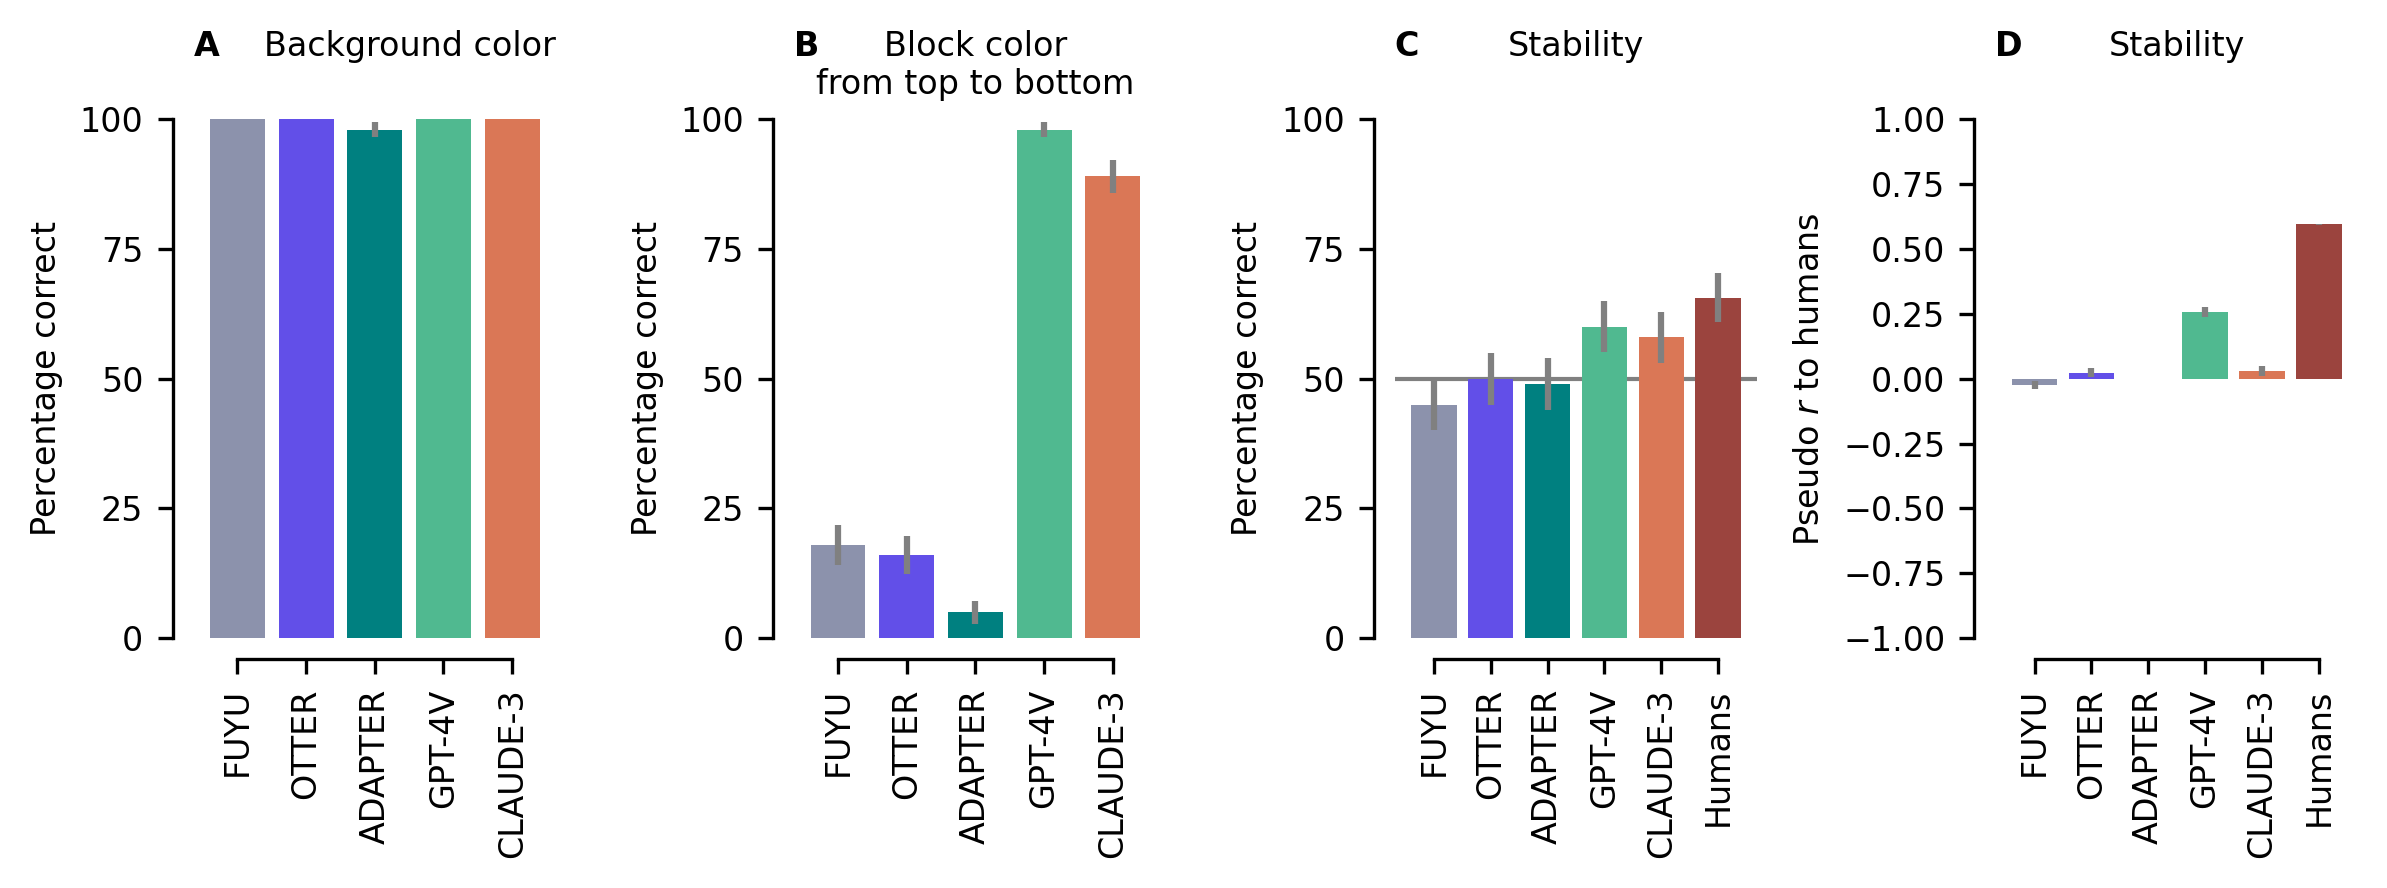

In [13]:
# Init plotting params
model_colors = plot_params()

# Prepare plot
num_subjects = len(subjects)
fig, axs = plt.subplots(1, 4, sharey=False, tight_layout=True, figsize=(8,3))  

# Plot A
axs[0].bar(np.arange(num_subjects), colors, zorder=2, color=model_colors)
axs[0].errorbar(np.arange(num_subjects), colors, colors_errs, ls="none", ecolor="gray")
axs[0].set_title("Background color\n", loc="right")
axs[0].set_title("A\n", fontweight='bold', loc='left', fontsize='medium')
axs[0].set_ylabel("Percentage correct")
axs[0].set_ylim(0, 100)
axs[0].set_yticks(np.arange(0, 110, 25))
axs[0].set_xticks(np.arange(num_subjects))

# Plot B
axs[1].bar(np.arange(num_subjects), topbottom, zorder=2, color=model_colors)
axs[1].errorbar(np.arange(num_subjects), topbottom, topbottom_errs, ls="none", ecolor="gray")
axs[1].set_title("Block color\nfrom top to bottom", loc="center")
axs[1].set_title("B\n", fontweight='bold', loc='left', fontsize='medium')
axs[1].set_ylabel("Percentage correct")
axs[1].set_ylim(0, 100)
axs[1].set_yticks(np.arange(0, 110, 25))
axs[1].set_xticks(np.arange(num_subjects))

# Plot C
axs[2].bar(np.arange(num_subjects+1), stability, zorder=2, color=model_colors)
axs[2].errorbar(np.arange(num_subjects+1), stability, stability_errs, ls="none", ecolor="gray")
axs[2].set_title("Stability\n", loc="center")
axs[2].set_title("C\n", fontweight='bold', loc='left', fontsize='medium')
axs[2].set_ylabel("Percentage correct")
axs[2].set_ylim(0, 100)
axs[2].set_yticks(np.arange(0, 110, 25))
axs[2].set_xticks(np.arange(num_subjects+1))
axs[2].axhline(50, xmin=0, xmax=num_subjects, color="gray", linestyle="-", linewidth=1.0, zorder=1)

# Plot D
axs[3].bar(np.arange(num_subjects+1), towers_lmer_coef, color=model_colors)
axs[3].errorbar(np.arange(num_subjects+1), towers_lmer_coef, towers_lmer_conf, ls="none", ecolor="gray")
axs[3].set_title("Stability\n", loc="center")
axs[3].set_title("D\n", fontweight='bold', loc='left', fontsize='medium')
axs[3].set_ylabel(f"Pseudo $r$ to humans")
axs[3].set_ylim(-1, 1)
#axs[3].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[3].set_xticks(np.arange(num_subjects+1))

# Despine and set x tick labels afterwards
sns.despine(offset=5, trim=True)
axs[0].set_xticklabels(subjects, rotation=90)
axs[1].set_xticklabels(subjects, rotation=90)
axs[2].set_xticklabels(np.hstack((subjects, "Humans")), rotation=90)
axs[3].set_xticklabels(np.hstack((subjects, "Humans")), rotation=90)
plt.savefig("figures/01_towers_main.pdf", dpi=300)

#### Additional: Are GPT-4V and CLAUDE-3 significantly better at getting stability right than chance?

In [ ]:
# Make contingency table
cont00 = np.sum(((models[models["Experiment"] == 3]["GPT-4V"]).values.astype(float) == 0) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 0))
cont01 = np.sum(((models[models["Experiment"] == 3]["GPT-4V"]).values.astype(float) == 0) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 1))
cont10 = np.sum(((models[models["Experiment"] == 3]["GPT-4V"]).values.astype(float) == 1) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 0))
cont11 = np.sum(((models[models["Experiment"] == 3]["GPT-4V"]).values.astype(float) == 1) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 1))
cont = [[cont00, cont01], [cont10, cont11]]
fisher = fisher_exact(cont, alternative="greater")
print(f"Fisher exact test for GPT-4V in stability judgements: {fisher.statistic:.4f}, with p-value: {fisher.pvalue:.4f}")

In [ ]:
# Make contingency table
cont00 = np.sum(((models[models["Experiment"] == 3]["CLAUDE-3"]).values.astype(float) == 0) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 0))
cont01 = np.sum(((models[models["Experiment"] == 3]["CLAUDE-3"]).values.astype(float) == 0) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 1))
cont10 = np.sum(((models[models["Experiment"] == 3]["CLAUDE-3"]).values.astype(float) == 1) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 0))
cont11 = np.sum(((models[models["Experiment"] == 3]["CLAUDE-3"]).values.astype(float) == 1) & (models[models["Experiment"] == 3]["GT"].values.astype(float) == 1))
cont = [[cont00, cont01], [cont10, cont11]]
fisher = fisher_exact(cont, alternative="greater")
print(f"Fisher exact test for CLAUDE-3 in stability judgements: {fisher.statistic:.4f}, with p-value: {fisher.pvalue:.4f}")

#### Additional: example trial plot

In [ ]:
# Get answers
human_mean = human_stability.iloc[:,1:].mean(axis=1)
gpt4v = models.loc[models["Experiment"] == 3, "GPT-4V"]
gt = models.loc[models["Experiment"] == 3, "GT"]

# Sort indices based on agreement with ground truth from low to high
human_sorted_inds = np.argsort(human_mean - gt.values.astype(float))
human_easy_imgs = models.loc[models["Experiment"] == 3, "Image"].iloc[human_sorted_inds[:20].values]
human_hard_imgs = models.loc[models["Experiment"] == 3, "Image"].iloc[human_sorted_inds[-20:].values]

# For experiment 3 get images all models got either right or wrong
gpt4v = models.loc[models["Experiment"] == 3, "GPT-4V"]
gpt4v_easy_inds = np.where((gpt4v.values.astype(float) - gt.values.astype(float)) == 0)
gpt4v_easy_imgs = models.loc[models["Experiment"] == 3, "Image"].iloc[gpt4v_easy_inds]
gpt4v_hard_inds = np.where(np.abs(gpt4v.values.astype(float) - gt.values.astype(float)) == 1)
gpt4v_hard_imgs = models.loc[models["Experiment"] == 3, "Image"].iloc[gpt4v_hard_inds]

# Get image numbers
easyhumanhardgpt4v = np.intersect1d(human_easy_imgs, gpt4v_hard_imgs)
easyhumaneasygpt4v = np.intersect1d(human_easy_imgs, gpt4v_easy_imgs)
hardhumanhardgpt4v = np.intersect1d(human_hard_imgs, gpt4v_hard_imgs) 
hardhumaneasygpt4v = np.intersect1d(human_hard_imgs, gpt4v_easy_imgs) 

# Get images that are either hard or easy for humans and GPT-4V
print(f"Images that are easy for humans but hard for GPT4-V: {easyhumanhardgpt4v}")
print(f"Images that are easy for humans and easy for GPT4-V: {easyhumaneasygpt4v}")
print(f"Images that are hard for humans and hard for GPT4-V: {hardhumanhardgpt4v}")
print(f"Images that are hard for humans but easy for GPT4-V: {hardhumaneasygpt4v}")

In [ ]:
# Prepare plot
fig, axs = plt.subplots(4, 4, sharey=False, tight_layout=True, figsize=(6,4))  

# First column: Easy for humans, hard for models
for row in range(4):
    axs[row, 0].imshow(plt.imread(f"eval/images/lerer/img_frame1_{easyhumanhardgpt4v[row]}.png"))
    fall = bool(models.loc[(models["Experiment"] == 3) & (models["Image"] == easyhumanhardgpt4v[row]), "GT"].values.astype(int))
    axs[row, 0].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 0].axis("off")

    axs[row, 1].imshow(plt.imread(f"eval/images/lerer/img_frame1_{easyhumaneasygpt4v[row]}.png"))
    fall = bool(models.loc[(models["Experiment"] == 3) & (models["Image"] == easyhumaneasygpt4v[row]), "GT"].values.astype(int))
    axs[row, 1].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 1].axis("off")

    axs[row, 2].imshow(plt.imread(f"eval/images/lerer/img_frame1_{hardhumanhardgpt4v[row]}.png"))
    fall = bool(models.loc[(models["Experiment"] == 3) & (models["Image"] == hardhumanhardgpt4v[row]), "GT"].values.astype(int))
    axs[row, 2].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 2].axis("off")

    axs[row, 3].imshow(plt.imread(f"eval/images/lerer/img_frame1_{hardhumaneasygpt4v[row]}.png"))
    fall = bool(models.loc[(models["Experiment"] == 3) & (models["Image"] == hardhumaneasygpt4v[row]), "GT"].values.astype(int))
    axs[row, 3].text(x=20, y=275, s=f"Fall: {fall}")
    axs[row, 3].axis("off")
    

# Set column titles
axs[0, 0].set_title("Humans right\nGPT4-V wrong", fontweight="bold")
axs[0, 1].set_title("Humans right\nGPT4-V right", fontweight="bold")
axs[0, 2].set_title("Humans wrong\nGPT4-V wrong", fontweight="bold")
axs[0, 3].set_title("Humans wrong\nGPT4-V right", fontweight="bold")
plt.savefig("figures/01_towers_examples.pdf", dpi=300)